## Описание проекта

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

### Описание производственного процесса

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша.

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).

## Импорты библиотек

In [4]:
# библиотеки
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math

# модели
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor

# метрика
from sklearn.metrics import mean_absolute_error

# расчеты
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# константы
RANDOM_STATE = 140823

# прочее
import warnings
warnings.filterwarnings("ignore")

## Исследовательский анализ данных

In [5]:
# Откроем файлы
try:
   data_arc = pd.read_csv('data_arc_new.csv')
   data_bulk = pd.read_csv('data_bulk_new.csv')
   data_bulk_time = pd.read_csv('data_bulk_time_new.csv', parse_dates = ['Bulk 1','Bulk 2','Bulk 3','Bulk 4','Bulk 5',
                                                                                'Bulk 6','Bulk 7','Bulk 8','Bulk 9','Bulk 10',
                                                                                'Bulk 11','Bulk 12','Bulk 13','Bulk 14','Bulk 15'])
   data_gas = pd.read_csv('data_gas_new.csv')
   data_temp = pd.read_csv('data_temp_new.csv')
   data_wire = pd.read_csv('data_wire_new.csv')
   data_wire_time = pd.read_csv('data_wire_time_new.csv', parse_dates = ['Wire 1', 'Wire 2', 'Wire 3', 'Wire 4',
                                                                                'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9'])
except:
  from google.colab import files
  uploaded = files.upload()

Saving data_arc_new.csv to data_arc_new.csv
Saving data_bulk_new.csv to data_bulk_new.csv
Saving data_bulk_time_new.csv to data_bulk_time_new.csv
Saving data_gas_new.csv to data_gas_new.csv
Saving data_temp_new.csv to data_temp_new.csv
Saving data_wire_new.csv to data_wire_new.csv
Saving data_wire_time_new.csv to data_wire_time_new.csv


In [8]:
import io
data_arc = pd.read_csv(io.BytesIO(uploaded['data_arc_new.csv']))
data_bulk = pd.read_csv(io.BytesIO(uploaded['data_bulk_new.csv']))
data_bulk_time = pd.read_csv(io.BytesIO(uploaded['data_bulk_time_new.csv']), parse_dates = ['Bulk 1','Bulk 2','Bulk 3','Bulk 4','Bulk 5',
                                                                                'Bulk 6','Bulk 7','Bulk 8','Bulk 9','Bulk 10',
                                                                                'Bulk 11','Bulk 12','Bulk 13','Bulk 14','Bulk 15'])
data_gas = pd.read_csv(io.BytesIO(uploaded['data_gas_new.csv']))
data_temp = pd.read_csv(io.BytesIO(uploaded['data_temp_new.csv']))
data_wire = pd.read_csv(io.BytesIO(uploaded['data_wire_new.csv']))
data_wire_time = pd.read_csv(io.BytesIO(uploaded['data_wire_time_new.csv']), parse_dates = ['Wire 1', 'Wire 2', 'Wire 3', 'Wire 4',
                                                                                'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9'])

### Обзор данных и графический анализ

Подробно изучим информацию о каждом датасете. В данном разделе только исследуем данные, предобработка (работа с пропусками, аномалиями и т.п.) будет проведена ниже в следующем разделе данной работы.

Поскольку у нас 7 датасетов, напишем функцию для вывода общей информации о них.

In [9]:
# функция вывода информации для ознакомления с данными
def info(data):
    print('Первые 5 строк:')
    display(data.head())
    print('-------------------------------------------------------------------------------------------')
    print('Общая информация:')
    display(data.info())
    print('-------------------------------------------------------------------------------------------')
    print('Статистика:')
    display(data.describe())
    print('-------------------------------------------------------------------------------------------')
    print('Количество дубликатов:')
    display(data.duplicated().sum())
    print('-------------------------------------------------------------------------------------------')
    print('Количество пропусков:')
    display(data.isna().sum())
    print('-------------------------------------------------------------------------------------------')
    print('Количество уникальных значений столбца key:')
    display(len(data['key'].unique()))
    print('-------------------------------------------------------------------------------------------')

#### Данные об электродах `data_arc`

In [10]:
info(data_arc)

Первые 5 строк:


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


-------------------------------------------------------------------------------------------
Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


None

-------------------------------------------------------------------------------------------
Статистика:


,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284


-------------------------------------------------------------------------------------------
Количество дубликатов:


0

-------------------------------------------------------------------------------------------
Количество пропусков:


key                     0
Начало нагрева дугой    0
Конец нагрева дугой     0
Активная мощность       0
Реактивная мощность     0
dtype: int64

-------------------------------------------------------------------------------------------
Количество уникальных значений столбца key:


3214

-------------------------------------------------------------------------------------------


Приведем тип данных в двух столбцах к типу datetime, поскольку фактически в них отображены дата и время.

In [12]:
# переводим дату в тип datetime
data_arc['Начало нагрева дугой'] = pd.to_datetime(data_arc['Начало нагрева дугой'], format='%Y-%m-%dT%H:%M:%S')
data_arc['Конец нагрева дугой'] = pd.to_datetime(data_arc['Конец нагрева дугой'], format='%Y-%m-%dT%H:%M:%S')

Наименования столбцов записаны не по правилам, однако это сделано без ошибок. Оставим в таком виде, поскольку в дальнейшем это будет удобно при выводе графиков, а также при составлении отчета для Заказчика.

В таблице со статистикой видим отрицательное значение реактивной мощности. Видим, что это единичное значение во всем датасете (выброс). На данном этапе не меняем исходные данные. В процессе предообработки, вероятно, стоит удалить данный выброс.

In [13]:
# проверка выборосов
data_arc.loc[data_arc['Реактивная мощность'] < 0]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924


Построим графики распределения признаков.

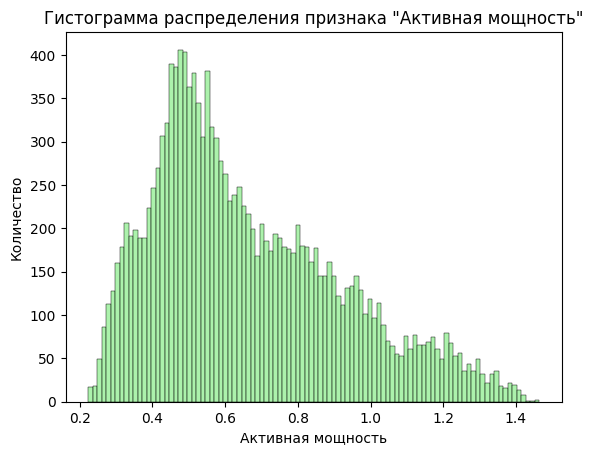

In [14]:
# визуализация Активной мощности
ax = sns.histplot(data_arc['Активная мощность'],
                  bins=100,
                  color='lightgreen')
ax.set_title('Гистограмма распределения признака "Активная мощность"')
ax.set(ylabel='Количество');

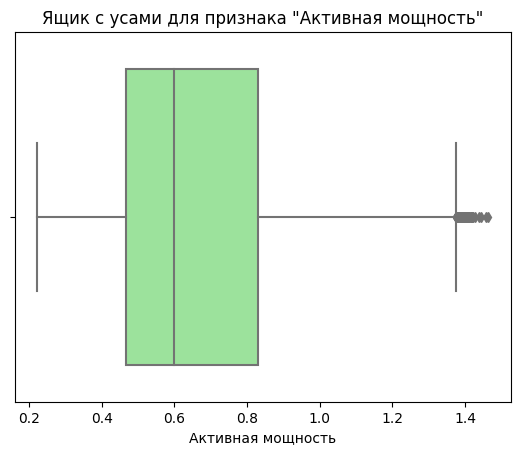

In [15]:
# визуализация Активной мощности
ab = sns.boxplot(data=data_arc, x='Активная мощность', color='lightgreen')
ab.set_title('Ящик с усами для признака "Активная мощность"');

В целом распределение похоже на нормальное со сдвигом влево. Существенных аномалий не наблюдается.

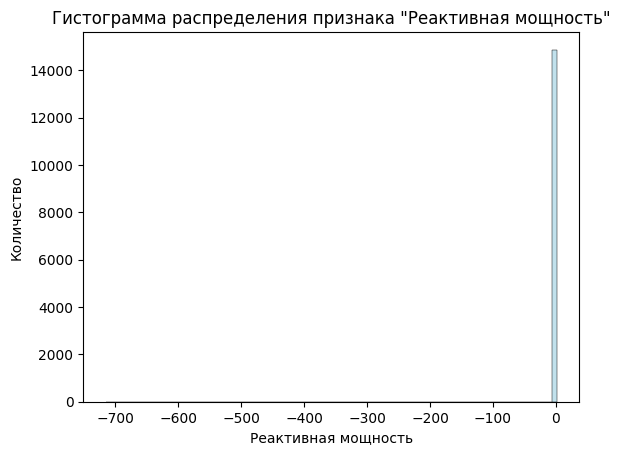

In [16]:
# визуализация Реактивной мощности
ay = sns.histplot(data_arc['Реактивная мощность'],
                  bins=100,
                  color='lightblue')
ay.set_title('Гистограмма распределения признака "Реактивная мощность"')
ay.set(ylabel='Количество');

Из-за выброса, обнаруженного ранее, график получается неинформативный. Удалим строку с выбросом и построим график повторно. Поскольку в данном разделе данные мы не преобразовываем, сохраним

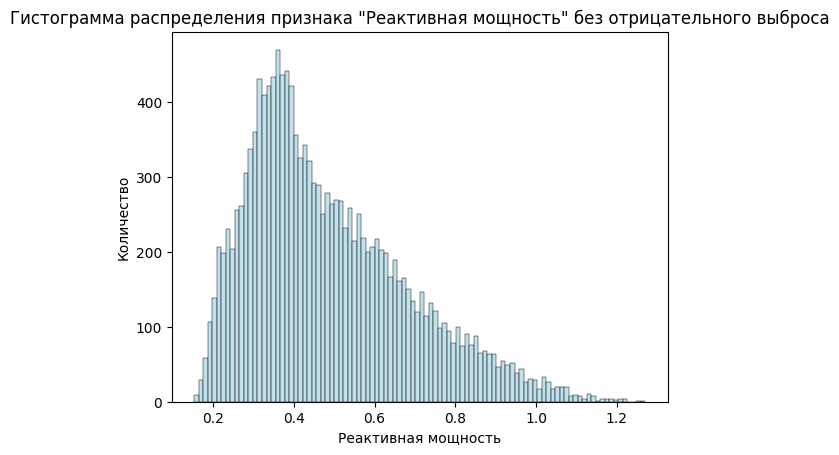

In [17]:
# визуализация Реактивной мощности
ay = sns.histplot(data_arc[data_arc['Реактивная мощность'] >= 0]['Реактивная мощность'],
                  bins=100,
                  color='lightblue')
ay.set_title('Гистограмма распределения признака "Реактивная мощность" без отрицательного выброса')
ay.set(ylabel='Количество');

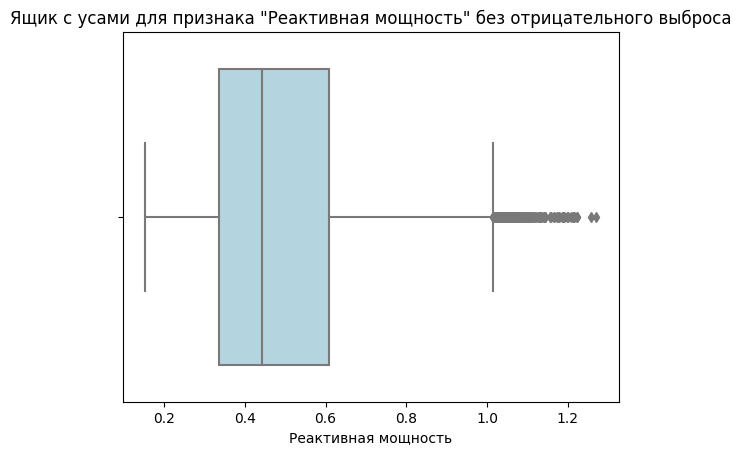

In [18]:
# визуализация Реактивной мощности
ab = sns.boxplot(data=data_arc[data_arc['Реактивная мощность'] >= 0], x='Реактивная мощность', color='lightblue')
ab.set_title('Ящик с усами для признака "Реактивная мощность" без отрицательного выброса');

В целом распределение похоже на нормальное со сдвигом влево. Существенных аномалий не наблюдается, кроме единственного отрицательного значения. В целом можно сказать, что гистограммы мощностей похожи между собой. Построим график взаимосвязи этих двух признаков и рассчитаем коэффициент корреляции. Для этого удалим строку с выбросом и сохраним данные в промежуточный датасет.

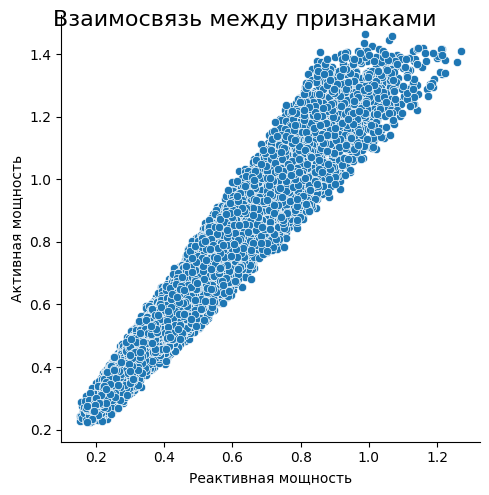

In [19]:
# удаляем выброс, сохраняем в отдельный датасет
x = data_arc[data_arc['Реактивная мощность'] >= 0]

# строим график зависимости
az = sns.relplot(x ="Реактивная мощность", y ="Активная мощность", data = x)
az.fig.suptitle('Взаимосвязь между признаками', fontsize=16);

In [20]:
# расчет корреляции
print('Корреляция Активной и Реактивной мощности', x['Активная мощность'].corr(x['Реактивная мощность']))

Корреляция Активной и Реактивной мощности 0.9663734456187297


**Промежуточный вывод:**
- пропусков и дубликатов в датасете нет;
- в столбце "Реактивная мощность" обнаружен единственный выброс - отрицательное значение. В дальнейшем следует удалить все данные по этой партии из датасета, поскольку сложно понять, откуда взялась такая ошибка;
- для каждой партии (key) в датасете приведено несколько замеров;
- существует сильная корреляция между признаками "Активная мощность" и "Реактивная мощность";
- для дальнейшей работы, возможно, будет необходимо найти суммарную мощность или энергию для каждой партии.

#### Данные о подаче сыпучих материалов (объём) `data_bulk`

In [21]:
info(data_bulk)

Первые 5 строк:


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


-------------------------------------------------------------------------------------------
Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

-------------------------------------------------------------------------------------------
Статистика:


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


-------------------------------------------------------------------------------------------
Количество дубликатов:


0

-------------------------------------------------------------------------------------------
Количество пропусков:


key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

-------------------------------------------------------------------------------------------
Количество уникальных значений столбца key:


3129

-------------------------------------------------------------------------------------------


Приведем наименование столбцов к нижнему регистру.

In [22]:
# предобработка таблицы data_bulk
data_bulk.columns = data_bulk.columns.str.lower()

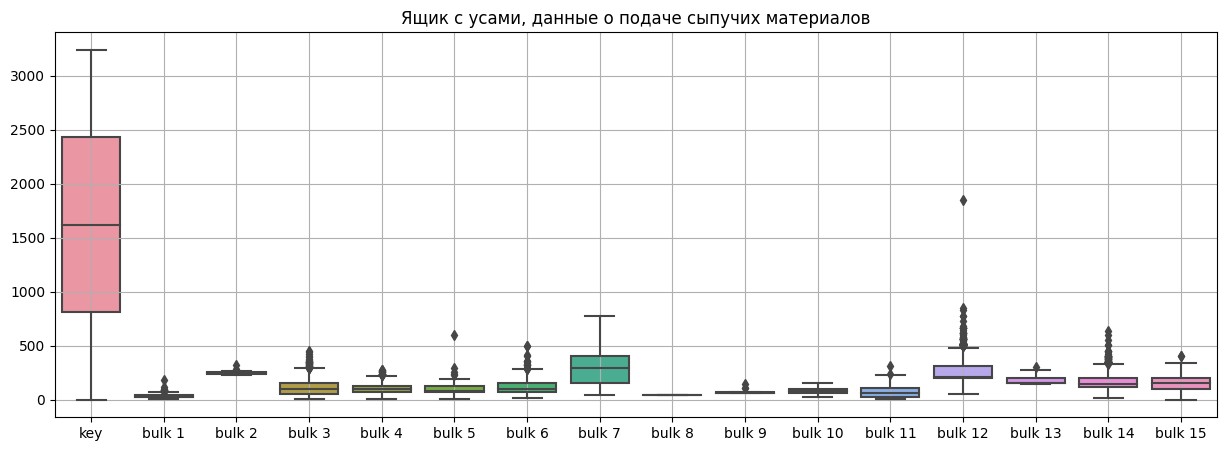

In [23]:
# построим боксплот для всех признаков
plt.figure(figsize=(15,5))
sns.boxplot(data=data_bulk).set_title('Ящик с усами, данные о подаче сыпучих материалов')
plt.grid();

**Промежуточный вывод:**
- дубликатов в датасете нет;
- довольно большое количество пропусков, вероятно, говорит о том, что добавка в данной партии не использовалась. При подготовке датасета можно заменить все пропуски нулями;
- в добавке под номером 12 имеется единичный выброс. Пока сложно сказать, это ошибка в данных или на производстве был добавлен такой большой объем добавки. Оставим без изменений.

#### Данные о подаче сыпучих материалов (время) `data_bulk_time`

In [24]:
info(data_bulk_time)

Первые 5 строк:


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaT,NaT,NaT,2019-05-03 11:28:48,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:24:31,NaT,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaT,NaT,NaT,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:53:30,NaT,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaT,NaT,NaT,2019-05-03 12:32:39,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:27:13,NaT,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaT,NaT,NaT,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:58:00,NaT,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,2019-05-03 13:34:12,2019-05-03 13:30:47


-------------------------------------------------------------------------------------------
Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   Bulk 1   252 non-null    datetime64[ns]
 2   Bulk 2   22 non-null     datetime64[ns]
 3   Bulk 3   1298 non-null   datetime64[ns]
 4   Bulk 4   1014 non-null   datetime64[ns]
 5   Bulk 5   77 non-null     datetime64[ns]
 6   Bulk 6   576 non-null    datetime64[ns]
 7   Bulk 7   25 non-null     datetime64[ns]
 8   Bulk 8   1 non-null      datetime64[ns]
 9   Bulk 9   19 non-null     datetime64[ns]
 10  Bulk 10  176 non-null    datetime64[ns]
 11  Bulk 11  177 non-null    datetime64[ns]
 12  Bulk 12  2450 non-null   datetime64[ns]
 13  Bulk 13  18 non-null     datetime64[ns]
 14  Bulk 14  2806 non-null   datetime64[ns]
 15  Bulk 15  2248

None

-------------------------------------------------------------------------------------------
Статистика:


,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


-------------------------------------------------------------------------------------------
Количество дубликатов:


0

-------------------------------------------------------------------------------------------
Количество пропусков:


key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

-------------------------------------------------------------------------------------------
Количество уникальных значений столбца key:


3129

-------------------------------------------------------------------------------------------


Тип данных во всех столбцах был приведен к типу datetime при открытии файла, поскольку изначально тип данных был 'object'. Приведем наименование столбцов к нижнему регистру.

In [25]:
# предобработка таблицы data_bulk_time
data_bulk_time.columns = data_bulk_time.columns.str.lower()

На первый взгляд кажется, что пропуски в таблицах `data_bulk` и `data_bulk_time` совпадают. Проверим, так ли это. Видим, что да.

In [26]:
# проверяем, совпадают ли пропуски
print((data_bulk_time.isna() == data_bulk.isna()).sum())

key        3129
bulk 1     3129
bulk 2     3129
bulk 3     3129
bulk 4     3129
bulk 5     3129
bulk 6     3129
bulk 7     3129
bulk 8     3129
bulk 9     3129
bulk 10    3129
bulk 11    3129
bulk 12    3129
bulk 13    3129
bulk 14    3129
bulk 15    3129
dtype: int64


**Промежуточный вывод:**
- дубликатов в датасете нет;
- довольно большое количество пропусков, которые совпадают с пропусками в таблице `data_bulk`;
- поскольку для модели обучения мы будем использовать данные только о начале нагрева партии и его окончании, то промежуточное время добавления добавок нам не требуется, необходимость в обработке пропусков отсутствует.

#### Данные о продувке сплава газом `data_gas`

In [27]:
info(data_gas)

Первые 5 строк:


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


-------------------------------------------------------------------------------------------
Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

-------------------------------------------------------------------------------------------
Статистика:


,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


-------------------------------------------------------------------------------------------
Количество дубликатов:


0

-------------------------------------------------------------------------------------------
Количество пропусков:


key      0
Газ 1    0
dtype: int64

-------------------------------------------------------------------------------------------
Количество уникальных значений столбца key:


3239

-------------------------------------------------------------------------------------------


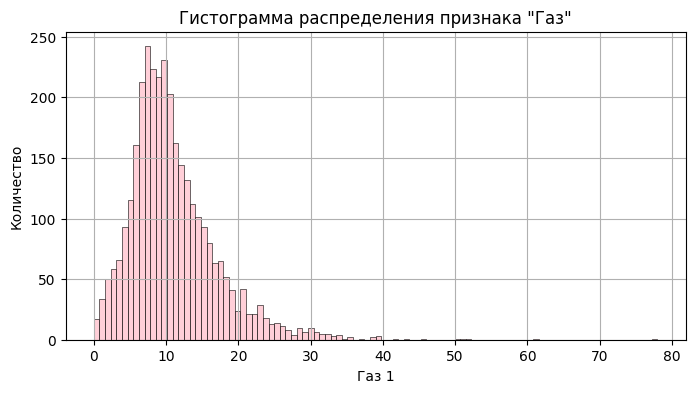

In [28]:
# визуализация данных о продувке газом
plt.figure(figsize=(8,4))
ax = sns.histplot(data_gas['Газ 1'],
                  bins=100,
                  color='pink')
ax.set_title('Гистограмма распределения признака "Газ"')
ax.set(ylabel='Количество')
plt.grid();

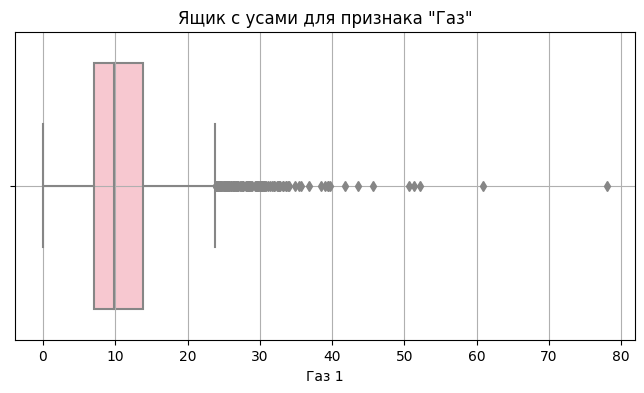

In [29]:
# визуализация данных о продувке газом
plt.figure(figsize=(8,4))
ab = sns.boxplot(data=data_gas, x='Газ 1', color='pink')
ab.set_title('Ящик с усами для признака "Газ"')
plt.grid();

**Промежуточный вывод:**
- пропусков и дубликатов в датасете нет;
- распределение признака похоже на нормальное со сдвигом влево. Есть несколько выбросов выше 50, но сложно сказать, ошибка ли это в данных или действительно было использовано большое количество газа на производстве. Оставим эти данные без изменений.

#### Результаты измерения температуры `data_temp`

In [30]:
info(data_temp)

Первые 5 строк:


,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


-------------------------------------------------------------------------------------------
Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


None

-------------------------------------------------------------------------------------------
Статистика:


,key,Температура
count,18092.000000,14665.000000
mean,1616.460977,1590.722741
std,934.641385,20.394381
min,1.000000,1191.000000
25%,807.750000,1580.000000
50%,1618.000000,1590.000000
75%,2429.000000,1599.000000
max,3241.000000,1705.000000


-------------------------------------------------------------------------------------------
Количество дубликатов:


0

-------------------------------------------------------------------------------------------
Количество пропусков:


key                0
Время замера       0
Температура     3427
dtype: int64

-------------------------------------------------------------------------------------------
Количество уникальных значений столбца key:


3216

-------------------------------------------------------------------------------------------


Приведем тип данных в столбце с датой к типу datetime.

In [31]:
# предобработка таблицы data_temp
data_temp['Время замера'] = pd.to_datetime(data_temp['Время замера'], format='%Y-%m-%dT%H:%M:%S')

В таблице со статистикой видим минимальное значение температуры 1191, хотя температура плавления стали существенно выше (от 1350 до 1535). Построим боксплот, чтобы оценить распределение.

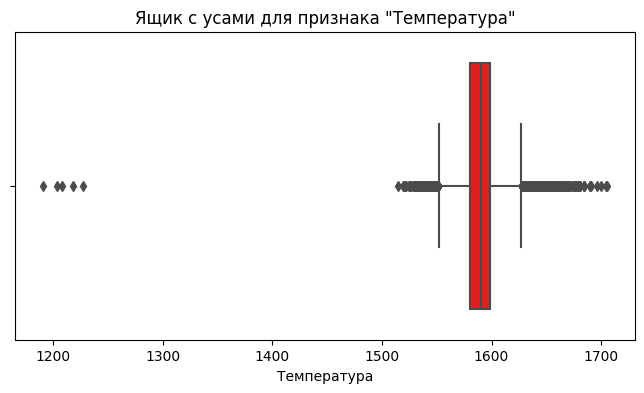

In [32]:
# визуализация данных о температуре
plt.figure(figsize=(8,4))
ab = sns.boxplot(data=data_temp, x='Температура', color='red')
ab.set_title('Ящик с усами для признака "Температура"');

In [33]:
# выведем строки с выбросами
data_temp.loc[data_temp['Температура'] < 1400]

,key,Время замера,Температура
4883,867,2019-06-06 08:03:39,1191.0
6784,1214,2019-06-18 08:01:03,1208.0
9050,1619,2019-07-03 02:34:41,1218.0
11495,2052,2019-07-25 08:49:15,1227.0
14283,2561,2019-08-12 18:49:29,1204.0


Видим 5 аномальных наблюдений. Возможно, сломался датчик во время этих замеров или ошибка закралась уже в датасет. В любом случае, эти данные нам необходимо будет в дальнейшем удалить (всю партию целиком).

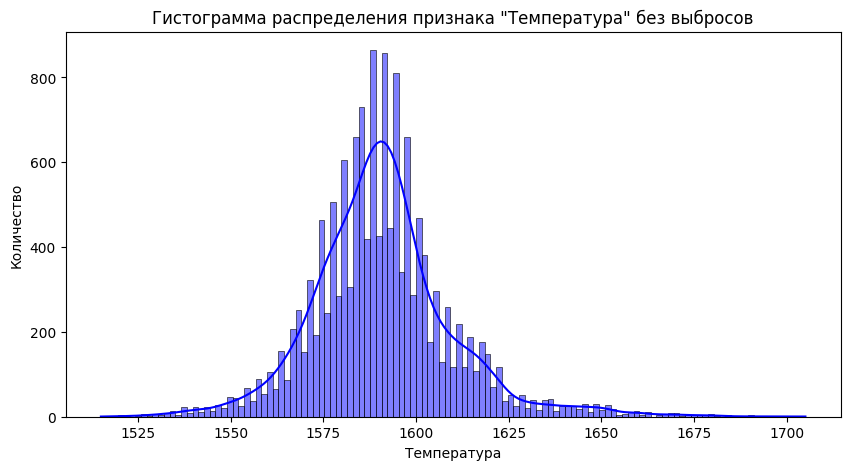

In [34]:
# визуализация Реактивной мощности
plt.figure(figsize=(10,5))
ay = sns.histplot(data_temp[data_temp['Температура'] > 1500]['Температура'],
                  kde=True,
                  color='blue')
ay.set_title('Гистограмма распределения признака "Температура" без выбросов')
ay.set(ylabel='Количество');

Без выбросов распределение похоже на нормальное.

Проверим, во всех ли партиях было несколько замеров температуры.

In [35]:
# группировка по партиям
key_group = data_temp.groupby(by = 'key').count()
key_group.query('Температура == 1')

,Время замера,Температура
key,,
195,1,1
279,1,1
2500,5,1
2501,7,1
2502,5,1
...,...,...
3237,6,1
3238,4,1
3239,9,1


**Промежуточный вывод:**
- дубликатов в датасете нет;
- имеются пропуски в столбце "Температура". Возможно, они обусловлены сломанным датчиком, поскольку время при этом зафиксировано. Пропуски в дальнейшем удалим;
- имеется несколько аномальных значений ниже температуры плавления стали, эти строки в дальнейшем удалим;
- 741 партия в датасете - имеется только один замер температуры. Это неинформативные данные, их необходимо удалить из финального датасета для обучения.

#### Данные о проволочных материалах (объём) `data_wire`

In [36]:
info(data_wire)

Первые 5 строк:


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


-------------------------------------------------------------------------------------------
Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

-------------------------------------------------------------------------------------------
Статистика:


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


-------------------------------------------------------------------------------------------
Количество дубликатов:


0

-------------------------------------------------------------------------------------------
Количество пропусков:


key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

-------------------------------------------------------------------------------------------
Количество уникальных значений столбца key:


3081

-------------------------------------------------------------------------------------------


Приведем наименование столбцов к нижнему регистру.

In [37]:
# предобработка таблицы data_wire
data_wire.columns = data_wire.columns.str.lower()

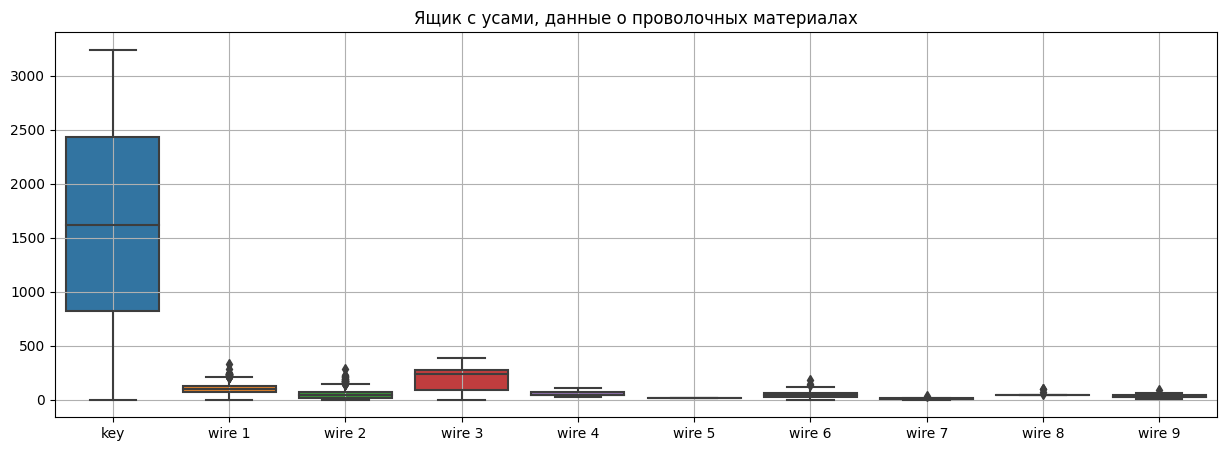

In [38]:
# построим боксплот для всех признаков
plt.figure(figsize=(15,5))
sns.boxplot(data=data_wire).set_title('Ящик с усами, данные о проволочных материалах')
plt.grid();

**Промежуточный вывод:**
- дубликатов в датасете нет;
- довольно большое количество пропусков, вероятно, говорит о том, что добавка в данной партии не использовалась. При подготовке датасета можно заменить все пропуски нулями;
- добавка под номером 5 используется крайне редко.

#### Данные о проволочных материалах (время) `data_wire_time`

In [39]:
info(data_wire_time)

Первые 5 строк:


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,2019-05-03 12:11:46,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,4,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaT,NaT,NaT,NaT,NaT,NaT,NaT


-------------------------------------------------------------------------------------------
Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   Wire 1  3055 non-null   datetime64[ns]
 2   Wire 2  1079 non-null   datetime64[ns]
 3   Wire 3  63 non-null     datetime64[ns]
 4   Wire 4  14 non-null     datetime64[ns]
 5   Wire 5  1 non-null      datetime64[ns]
 6   Wire 6  73 non-null     datetime64[ns]
 7   Wire 7  11 non-null     datetime64[ns]
 8   Wire 8  19 non-null     datetime64[ns]
 9   Wire 9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB


None

-------------------------------------------------------------------------------------------
Статистика:


,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


-------------------------------------------------------------------------------------------
Количество дубликатов:


0

-------------------------------------------------------------------------------------------
Количество пропусков:


key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

-------------------------------------------------------------------------------------------
Количество уникальных значений столбца key:


3081

-------------------------------------------------------------------------------------------


Тип данных во всех столбцах был приведен к типу datetime при открытии файла, поскольку изначально тип данных был 'object'. Приведем наименование столбцов к нижнему регистру.

In [40]:
# предобработка таблицы data_bulk_time
data_wire_time.columns = data_wire_time.columns.str.lower()

На первый взгляд кажется, что пропуски в таблицах `data_wire` и `data_wire_time` совпадают. Проверим, так ли это. Видим, что да.

In [41]:
# проверяем, совпадают ли пропуски
print((data_wire_time.isna() == data_wire.isna()).sum())

key       3081
wire 1    3081
wire 2    3081
wire 3    3081
wire 4    3081
wire 5    3081
wire 6    3081
wire 7    3081
wire 8    3081
wire 9    3081
dtype: int64


**Промежуточный вывод:**
- дубликатов в датасете нет;
- довольно большое количество пропусков, которые совпадают с пропусками в таблице `data_wire`;
- поскольку для модели обучения мы будем использовать данные только о начале нагрева партии и его окончании, то промежуточное время добавления добавок нам не требуется, необходимость в обработке пропусков отсутствует.

#### Вывод

Мы ознакомились с данными и провели исследовательский анализ этих данных. Все ячейки с датами переведены в формат datetime для дальнейшего удобства работы с ними.

После ознакомления с данными можно сделать **следующие выводы**:
- нам предоставлены данные о 3241 партии (key);
- при этом во всех таблицах количество уникальных значений столбца `key` меньше, чем 3241, то есть отсутствуют данные о части партий. Таким образом, при объединении таблиц по столбцу `key` в итоговой таблице будут пропуски данных;
- обнаружены явные ошибки в данных (низкая температура, отрицательная реактивная мощность). На этапе предобработки данные этих партий необходимо будет удалить;
- 741 партия в датасете - имеется только один замер температуры. Это неинформативные данные, поскольку для обучения модели нам необходимо знать минимум о двух замерах - начальном и конечном. Эти данные необходимо удалить на этапе предобработки;
- существует сильная корреляция между признаками "Активная мощность" и "Реактивная мощность";
- пропуски в таблицах с данными о легирующих добавках говорят о том, что добавка не была использована. Такие пропуски необходимо заменить нулями;
- таблицы с данными о времени добавления добавок для обучения не понадобятся.

**Работа с пропусками и аномалиями** будет проведена позднее в данной работе, в ходе предобработки данных.

## Предобработка данных

### Работа с пропусками

Логику работы с пропусками мы определили ранее в разделе EDA:
- таблицы `data_bulk` и `data_wire` - заменим все пропуски нулями;
- таблица `data_temp` - пропуски удаляем, при этом удаляем не только строки, но и партии с пропусками целиком.

В остальных таблицах пропусков либо нет, либо для дальнейшей работы они нам не требуются.

#### Пропуски, таблица `data_bulk`

In [42]:
# инфо до удаления (контроль)
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   bulk 1   252 non-null    float64
 2   bulk 2   22 non-null     float64
 3   bulk 3   1298 non-null   float64
 4   bulk 4   1014 non-null   float64
 5   bulk 5   77 non-null     float64
 6   bulk 6   576 non-null    float64
 7   bulk 7   25 non-null     float64
 8   bulk 8   1 non-null      float64
 9   bulk 9   19 non-null     float64
 10  bulk 10  176 non-null    float64
 11  bulk 11  177 non-null    float64
 12  bulk 12  2450 non-null   float64
 13  bulk 13  18 non-null     float64
 14  bulk 14  2806 non-null   float64
 15  bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [43]:
# заменим пропуски на нули
data_bulk = data_bulk.fillna(0)

# проверим результат
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   bulk 1   3129 non-null   float64
 2   bulk 2   3129 non-null   float64
 3   bulk 3   3129 non-null   float64
 4   bulk 4   3129 non-null   float64
 5   bulk 5   3129 non-null   float64
 6   bulk 6   3129 non-null   float64
 7   bulk 7   3129 non-null   float64
 8   bulk 8   3129 non-null   float64
 9   bulk 9   3129 non-null   float64
 10  bulk 10  3129 non-null   float64
 11  bulk 11  3129 non-null   float64
 12  bulk 12  3129 non-null   float64
 13  bulk 13  3129 non-null   float64
 14  bulk 14  3129 non-null   float64
 15  bulk 15  3129 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


#### Пропуски, таблица `data_wire`

In [44]:
# инфо до удаления (контроль)
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   wire 1  3055 non-null   float64
 2   wire 2  1079 non-null   float64
 3   wire 3  63 non-null     float64
 4   wire 4  14 non-null     float64
 5   wire 5  1 non-null      float64
 6   wire 6  73 non-null     float64
 7   wire 7  11 non-null     float64
 8   wire 8  19 non-null     float64
 9   wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [45]:
# заменим пропуски на нули
data_wire = data_wire.fillna(0)

# проверим результат
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   wire 1  3081 non-null   float64
 2   wire 2  3081 non-null   float64
 3   wire 3  3081 non-null   float64
 4   wire 4  3081 non-null   float64
 5   wire 5  3081 non-null   float64
 6   wire 6  3081 non-null   float64
 7   wire 7  3081 non-null   float64
 8   wire 8  3081 non-null   float64
 9   wire 9  3081 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


#### Пропуски, таблица `data_temp`

In [46]:
# инфо до удаления (контроль)
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           18092 non-null  int64         
 1   Время замера  18092 non-null  datetime64[ns]
 2   Температура   14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB


In [47]:
# список партий с пропусками в температуре
temp_nan = data_temp[data_temp['Температура'].isna()]['key'].unique()

# удалим партии с пропусками в температуре
data_temp = data_temp.query('key not in @temp_nan')

# проверим результат
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13926 entries, 0 to 13925
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           13926 non-null  int64         
 1   Время замера  13926 non-null  datetime64[ns]
 2   Температура   13926 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 435.2 KB


**Вывод:** в таблицах `data_bulk` и `data_wire` заменили все пропуски нулями, в таблице `data_temp` - удалили все партии, где были пропуски в столбце "температура".

### Работа с выбросами / аномалиями

Логику работы с выбросами мы определили ранее в разделе EDA. Выбросы, связанные с ошибками (например, сбой датчика) - удаляем, поскольку доверять таким данным нельзя. Все прочие выбросы, которые действительно могут случиться в реальной практике - оставляем без изменений.
- таблица `data_arc` - имеется отрицательное значение реактивной мощности. Необходимо удалить всю партию целиком;
- таблица `data_temp` - в нескольких замерах температура ниже плавления стали (около 1200). Есть партии только с 1 замером температуры, что неинформативно для дальшейших целей обучения. Необходимо удалить такие партии целиком.

#### Аномалии, таблица `data_arc`

In [48]:
# определим номер партии с отр.реактивной мощностью
data_arc[data_arc['Реактивная мощность'] < 0]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924


In [49]:
# инфо до удаления (контроль)
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


In [50]:
# удалим всю партию из датасета
data_arc = data_arc[data_arc['key'] != 2116]

# проверим результат
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14872 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14872 non-null  int64         
 1   Начало нагрева дугой  14872 non-null  datetime64[ns]
 2   Конец нагрева дугой   14872 non-null  datetime64[ns]
 3   Активная мощность     14872 non-null  float64       
 4   Реактивная мощность   14872 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 697.1 KB


#### Аномалии, таблица `data_temp`

In [51]:
# выведем строки с выбросами температуры
data_temp.loc[data_temp['Температура'] < 1500]

,key,Время замера,Температура
4883,867,2019-06-06 08:03:39,1191.0
6784,1214,2019-06-18 08:01:03,1208.0
9050,1619,2019-07-03 02:34:41,1218.0
11495,2052,2019-07-25 08:49:15,1227.0


In [52]:
# инфо до удаления (контроль)
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13926 entries, 0 to 13925
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           13926 non-null  int64         
 1   Время замера  13926 non-null  datetime64[ns]
 2   Температура   13926 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 435.2 KB


In [53]:
# список партий с низкой температурой
temp_min = data_temp.loc[data_temp['Температура'] < 1500]['key'].tolist()

# удалим данные с одним замером
data_temp = data_temp.query('key not in @temp_min')

В разделе EDA мы также определили еще одну проблему таблицы `data_temp` - у части партий имеется только один замер температуры. Это неинформативные данные, их необходимо удалить.

In [54]:
# группировка по партиям
key_group = data_temp.groupby(by = 'key', as_index=False).count()

# список партий с одним замером
one_temp = key_group[key_group['Температура']== 1]['key'].tolist()

In [55]:
# удалим данные с одним замером
data_temp = data_temp.query('key not in @one_temp')

# проверим результат
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13903 entries, 0 to 13925
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           13903 non-null  int64         
 1   Время замера  13903 non-null  datetime64[ns]
 2   Температура   13903 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 434.5 KB


**Вывод:** в результате предобработки мы удалили из датасетов все партии с явными ошибками в данных (отрицательная реактивная мощность, неадекватно низкая температура плавления стали).

### Генерация новых признаков

В разделе EDA мы определили, что существует очень сильная корреляция (коэффициент Пирсона = 0,96) между признаками "Активная мощность" и "Реактивная мощность". Чтобы модель не переобучилась, рассчитаем энергию для дальнейшего использования ее при обучении.

Мощность (Р) - это затраты энергии (W) на единицу времени (T). Рассчитаем затраченную энергию на каждый замер в таблицу `data_arc`.

In [56]:
# добавим столбец "время нагрева в секундах"
data_arc['Время нагрева'] = (data_arc['Конец нагрева дугой'] - data_arc['Начало нагрева дугой']).dt.seconds

# добавим столбец "энергия"
data_arc['Энергия'] = data_arc['Активная мощность'] * data_arc['Время нагрева']

# проверим результат
data_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Время нагрева,Энергия
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,228,69.569640
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,185,141.646730
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,172,99.813836
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,365,189.251040
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,148,128.335684


**Вывод:** чтобы модель не переобучалась, добавили новый признак "Энергия". Остальные данные из таблицы для обучения нам не потребуются.
Еще один новый признак - время между первым и последним замером температуры - добавим чуть позднее в процессе обработки таблицы `data_temp`.

### Подготовка итоговой таблицы с признаками

Объединим все необходимые нам данные в одну таблицу по номеру партии (key). Наш таргет (последний замер температуры) находится в таблице `data_temp`, начнем с неё. В таблице приведено по несколько замеров температуры для каждой партии, на первом этапе нам необходимо отдельно выделить первый и последний замеры в партии.

In [57]:
# группируем данные и форматируем таблицу
data_temp_agg = data_temp.groupby(by ='key').agg(['first', 'last']).reset_index()
data_temp_agg.droplevel(level=0, axis=1)
data_temp_agg.columns = ['key', 'time_start', 'time_end','temp_start','temp_end']
data_temp_agg

,key,time_start,time_end,temp_start,temp_end
0,1,2019-05-03 11:02:04,2019-05-03 11:30:38,1571.0,1613.0
1,2,2019-05-03 11:34:04,2019-05-03 11:55:09,1581.0,1602.0
2,3,2019-05-03 12:06:44,2019-05-03 12:35:57,1596.0,1599.0
3,4,2019-05-03 12:39:27,2019-05-03 12:59:47,1601.0,1625.0
4,5,2019-05-03 13:11:03,2019-05-03 13:36:39,1576.0,1602.0
...,...,...,...,...,...
2466,2495,2019-08-10 11:27:47,2019-08-10 11:50:47,1570.0,1591.0
2467,2496,2019-08-10 11:56:48,2019-08-10 12:25:13,1554.0,1591.0
2468,2497,2019-08-10 12:37:26,2019-08-10 12:53:28,1571.0,1589.0
2469,2498,2019-08-10 12:58:11,2019-08-10 13:23:31,1591.0,1594.0


Мы получили таблицу с данными по температуре в начале нагрева и в конце в разрезе каждой партии. В качестве дополнительного признака добавим также столбец со временем между первым и последним замером (в секундах). А столбцы с датами после этого удалим, они нам не потребуются при обучении.

In [58]:
# добавим новый признак - время между первым и последним замером
data_temp_agg['full_time'] = (data_temp_agg['time_end'] - data_temp_agg['time_start']) / np.timedelta64 ( 1 , 's')

# удалим лишние столбцы
data_temp_agg = data_temp_agg.drop(columns=['time_start', 'time_end'])
data_temp_agg.head()

,key,temp_start,temp_end,full_time
0,1,1571.0,1613.0,1714.0
1,2,1581.0,1602.0,1265.0
2,3,1596.0,1599.0,1753.0
3,4,1601.0,1625.0,1220.0
4,5,1576.0,1602.0,1536.0


Аналогичным образом подготовим таблицу `data_arc` - сгруппируем данные по номеру партии и посчитаем энергию, затраченную на каждую партию.

In [59]:
# группируем данные
data_arc_agg = data_arc.groupby(by ='key', as_index = False).sum()

# таблица до преобразования (контроль)
display(data_arc_agg.head())

# удалим лишние столбцы и переименуем шапку
data_arc_agg = data_arc_agg[['key', 'Энергия']]
data_arc_agg = data_arc_agg.rename(columns={'Энергия': 'energy'})
data_arc_agg.head()

,key,Активная мощность,Реактивная мощность,Время нагрева,Энергия
0,1,3.036730,2.142821,1098,628.616930
1,2,2.139408,1.453357,811,395.281800
2,3,4.063641,2.937457,655,581.774624
3,4,2.706489,2.056992,741,543.710274
4,5,2.252950,1.687991,869,412.180480


,key,energy
0,1,628.616930
1,2,395.281800
2,3,581.774624
3,4,543.710274
4,5,412.180480


Проверим, что получилось с таблицами после агрегации (ячейки ниже). Видим, что пропусков нет, типы данных в порядке.

In [60]:
data_temp_agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2471 entries, 0 to 2470
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   key         2471 non-null   int64  
 1   temp_start  2471 non-null   float64
 2   temp_end    2471 non-null   float64
 3   full_time   2471 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 77.3 KB


In [61]:
data_arc_agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3213 entries, 0 to 3212
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3213 non-null   int64  
 1   energy  3213 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.3 KB


Все таблицы подготовлены, в каждой из них значение столбца `key` уникально, можно объединить все датафреймы в один. Объединять будем с помощью inner_join, чтобы в итоге получить только те партии, в которых есть все данные.

In [62]:
# объединяем таблицы
data = data_temp_agg.merge(data_arc_agg, how='inner', on='key')\
                    .merge(data_gas, how='inner', on='key')\
                    .merge(data_bulk, how='inner', on='key')\
                    .merge(data_wire, how='inner', on='key')

# проверим результат
display(data.head())
data.info()

,key,temp_start,temp_end,full_time,energy,Газ 1,bulk 1,bulk 2,bulk 3,bulk 4,...,bulk 15,wire 1,wire 2,wire 3,wire 4,wire 5,wire 6,wire 7,wire 8,wire 9
0,1,1571.0,1613.0,1714.0,628.616930,29.749986,0.0,0.0,0.0,43.0,...,154.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1581.0,1602.0,1265.0,395.281800,12.555561,0.0,0.0,0.0,73.0,...,154.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,1596.0,1599.0,1753.0,581.774624,28.554793,0.0,0.0,0.0,34.0,...,153.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,1601.0,1625.0,1220.0,543.710274,18.841219,0.0,0.0,0.0,81.0,...,154.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,1576.0,1602.0,1536.0,412.180480,5.413692,0.0,0.0,0.0,78.0,...,152.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2324 entries, 0 to 2323
Data columns (total 30 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   key         2324 non-null   int64  
 1   temp_start  2324 non-null   float64
 2   temp_end    2324 non-null   float64
 3   full_time   2324 non-null   float64
 4   energy      2324 non-null   float64
 5   Газ 1       2324 non-null   float64
 6   bulk 1      2324 non-null   float64
 7   bulk 2      2324 non-null   float64
 8   bulk 3      2324 non-null   float64
 9   bulk 4      2324 non-null   float64
 10  bulk 5      2324 non-null   float64
 11  bulk 6      2324 non-null   float64
 12  bulk 7      2324 non-null   float64
 13  bulk 8      2324 non-null   float64
 14  bulk 9      2324 non-null   float64
 15  bulk 10     2324 non-null   float64
 16  bulk 11     2324 non-null   float64
 17  bulk 12     2324 non-null   float64
 18  bulk 13     2324 non-null   float64
 19  bulk 14     2324 non-null  

In [63]:
# переименуем столбец "Газ 1"
data = data.rename(columns={'Газ 1': 'gas_1'})

In [64]:
# проверим, остались ли пропуски
data.isna().sum()

key           0
temp_start    0
temp_end      0
full_time     0
energy        0
gas_1         0
bulk 1        0
bulk 2        0
bulk 3        0
bulk 4        0
bulk 5        0
bulk 6        0
bulk 7        0
bulk 8        0
bulk 9        0
bulk 10       0
bulk 11       0
bulk 12       0
bulk 13       0
bulk 14       0
bulk 15       0
wire 1        0
wire 2        0
wire 3        0
wire 4        0
wire 5        0
wire 6        0
wire 7        0
wire 8        0
wire 9        0
dtype: int64

Проверим, не осталось ли у нас столбцов с нулями.

In [65]:
data.sum()

key           2.907650e+06
temp_start    3.689045e+06
temp_end      3.702998e+06
full_time     5.400237e+06
energy        1.253522e+06
gas_1         2.644446e+04
bulk 1        7.983000e+03
bulk 2        3.313000e+03
bulk 3        1.099650e+05
bulk 4        8.679600e+04
bulk 5        6.149000e+03
bulk 6        5.210300e+04
bulk 7        4.669000e+03
bulk 8        4.900000e+01
bulk 9        1.036000e+03
bulk 10       1.176800e+04
bulk 11       9.887000e+03
bulk 12       4.847810e+05
bulk 13       2.486000e+03
bulk 14       3.577860e+05
bulk 15       2.790620e+05
wire 1        2.380331e+05
wire 2        4.093311e+04
wire 3        7.534119e+03
wire 4        7.139548e+02
wire 5        0.000000e+00
wire 6        2.279672e+03
wire 7        1.481366e+01
wire 8        7.250433e+02
wire 9        7.385560e+02
dtype: float64

Признак `wire 5` не содержит в себе данных, все значения равны нулю. Удалим этот столбец.

При обзоре данных в разделе 3.1.2 в таблице info() мы видели, что столбец `bulk 8` содержит всего 1 ненулевое значение. В таком случае можно удалить этот признак из итоговой таблицы, поскольку он не окажет влияния на обучение, только создаст "шум". Проверим, так ли это. И удалим столбец в случае необходимости.

In [66]:
# проверяем столбец 'bulk 8' на наличие значений
data['bulk 8'].sort_values(ascending=False)

1664    49.0
0        0.0
1552     0.0
1546     0.0
1547     0.0
        ... 
774      0.0
775      0.0
776      0.0
777      0.0
2323     0.0
Name: bulk 8, Length: 2324, dtype: float64

Действительно, столбец содержит всего одно ненулевое значение. Удалим этот столбец.

In [67]:
# удалим wire 5 и bulk 8
data = data.drop(columns=['wire 5', 'bulk 8'])

# проверим результат
data.head()

,key,temp_start,temp_end,full_time,energy,gas_1,bulk 1,bulk 2,bulk 3,bulk 4,...,bulk 14,bulk 15,wire 1,wire 2,wire 3,wire 4,wire 6,wire 7,wire 8,wire 9
0,1,1571.0,1613.0,1714.0,628.616930,29.749986,0.0,0.0,0.0,43.0,...,150.0,154.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1581.0,1602.0,1265.0,395.281800,12.555561,0.0,0.0,0.0,73.0,...,149.0,154.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2,3,1596.0,1599.0,1753.0,581.774624,28.554793,0.0,0.0,0.0,34.0,...,152.0,153.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
3,4,1601.0,1625.0,1220.0,543.710274,18.841219,0.0,0.0,0.0,81.0,...,153.0,154.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
4,5,1576.0,1602.0,1536.0,412.180480,5.413692,0.0,0.0,0.0,78.0,...,151.0,152.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0


**Вывод:** в результате мы получили финальный датасет с набором признаков. Датасет готов к дальнейшей работе, пропусков нет, наименования столбцов записаны корректно. Целевой признак - столбец `temp_end`. Помимо данных из исходных датасетов было добавлено 2 новых признака:
- суммарная энергия, затраченная на партию;
- время между первым и последним замером температуры в партии.

## Исследовательский анализ итогового датасета

Посмотрим основную информацию о датасете. В итоге получилось 2324 строки и 28 признаков, включая целевой (temp_end).

In [68]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2324 entries, 0 to 2323
Data columns (total 28 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   key         2324 non-null   int64  
 1   temp_start  2324 non-null   float64
 2   temp_end    2324 non-null   float64
 3   full_time   2324 non-null   float64
 4   energy      2324 non-null   float64
 5   gas_1       2324 non-null   float64
 6   bulk 1      2324 non-null   float64
 7   bulk 2      2324 non-null   float64
 8   bulk 3      2324 non-null   float64
 9   bulk 4      2324 non-null   float64
 10  bulk 5      2324 non-null   float64
 11  bulk 6      2324 non-null   float64
 12  bulk 7      2324 non-null   float64
 13  bulk 9      2324 non-null   float64
 14  bulk 10     2324 non-null   float64
 15  bulk 11     2324 non-null   float64
 16  bulk 12     2324 non-null   float64
 17  bulk 13     2324 non-null   float64
 18  bulk 14     2324 non-null   float64
 19  bulk 15     2324 non-null  

In [69]:
data.describe()

,key,temp_start,temp_end,full_time,energy,gas_1,bulk 1,bulk 2,bulk 3,bulk 4,...,bulk 14,bulk 15,wire 1,wire 2,wire 3,wire 4,wire 6,wire 7,wire 8,wire 9
count,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,...,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000
mean,1251.140275,1587.368761,1593.372633,2323.682014,539.381127,11.378854,3.435026,1.425559,47.317126,37.347676,...,153.952668,120.078313,102.423900,17.613213,3.241876,0.307209,0.980926,0.006374,0.311981,0.317795
std,715.027927,23.627590,11.207457,1385.809791,257.301093,6.397008,12.424463,19.102530,75.238050,58.677890,...,81.410544,84.655967,43.540975,33.648176,27.972523,4.762842,8.702531,0.205926,4.407419,3.460248
min,1.000000,1519.000000,1541.000000,339.000000,26.187544,0.008399,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,628.750000,1571.000000,1587.000000,1580.500000,368.304687,7.282534,0.000000,0.000000,0.000000,0.000000,...,105.000000,0.000000,73.204559,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1254.500000,1587.000000,1593.000000,2046.500000,508.538758,10.100687,0.000000,0.000000,0.000000,0.000000,...,149.000000,107.000000,101.103600,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1867.250000,1603.000000,1598.000000,2793.500000,679.198659,14.218487,0.000000,0.000000,80.000000,77.250000,...,204.000000,204.000000,128.075222,23.102560,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2499.000000,1660.000000,1653.000000,23674.000000,3718.054401,77.995040,185.000000,325.000000,454.000000,281.000000,...,636.000000,405.000000,330.314424,282.780152,385.008668,113.231044,180.454575,8.490040,102.762401,62.025600


Построим графики распределения признаков.

Данные о продувке газом и о подаче материалов были исследованы ранее в разделе EDA. Проанализируем новые признаки `full_time` и `energy`, а затем проверим датасет на взаимную корреляцию признаков.

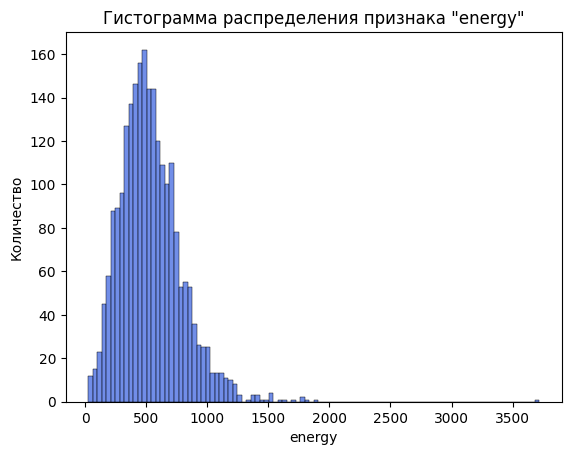

In [70]:
# визуализация признака "полная мощность"
ax = sns.histplot(data['energy'],
                  bins=100,
                  color='royalblue')
ax.set_title('Гистограмма распределения признака "energy"')
ax.set(ylabel='Количество');

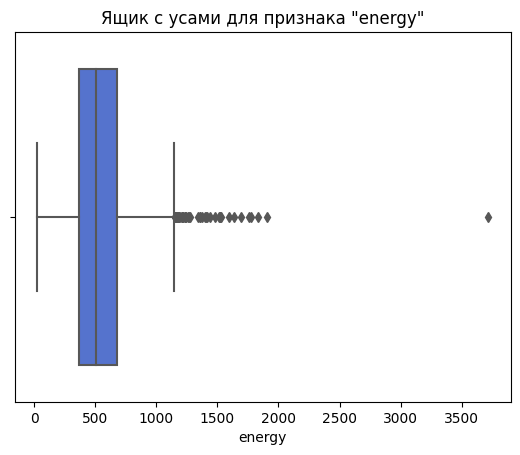

In [71]:
# визуализация полной мощности
ab = sns.boxplot(data=data, x='energy', color='royalblue')
ab.set_title('Ящик с усами для признака "energy"');

В целом распределение похоже на нормальное со сдвигом влево. Имеется один существенный выброс - значение свыше 3500. Сложно сказать, является ли это ошибкой в данных или это была неудачная партия. В целом значение не выглядит невероятным, поэтому оставим эти данные без изменений.

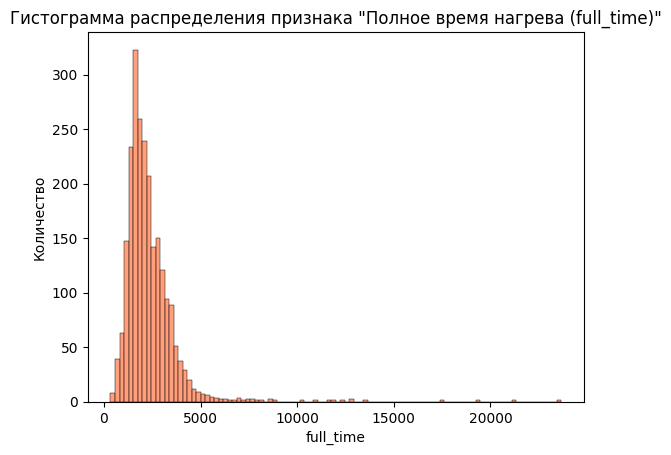

In [72]:
# визуализация признака "полное время нагрева"
ax = sns.histplot(data['full_time'],
                  bins=100,
                  color='coral')
ax.set_title('Гистограмма распределения признака "Полное время нагрева (full_time)"')
ax.set(ylabel='Количество');

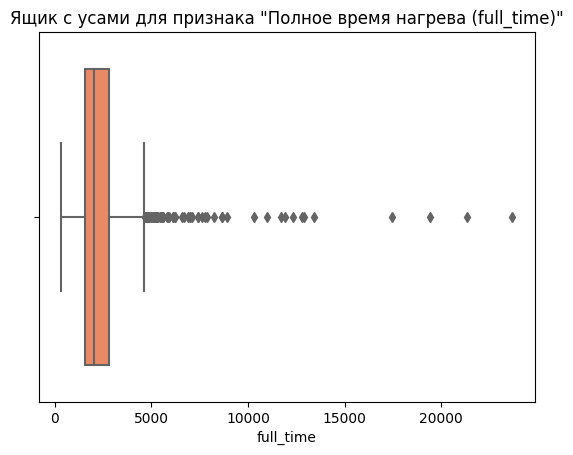

In [73]:
# визуализация полной мощности
ab = sns.boxplot(data=data, x='full_time', color='coral')
ab.set_title('Ящик с усами для признака "Полное время нагрева (full_time)"');

Здесь мы видим достаточно большое количество выбросов, особенно выделяются 4 партии со времененем нагрева более 4,5 часов (16 тыс. секунд). Вероятно, в процессе плавления в этих партиях что-то пошло не по плану, либо это были особые партии с особым способом плавления. В любом случае, удалять эти партии из датасета не считаю верным.

Следующим этапом построим **тепловую карту корреляции признаков**.

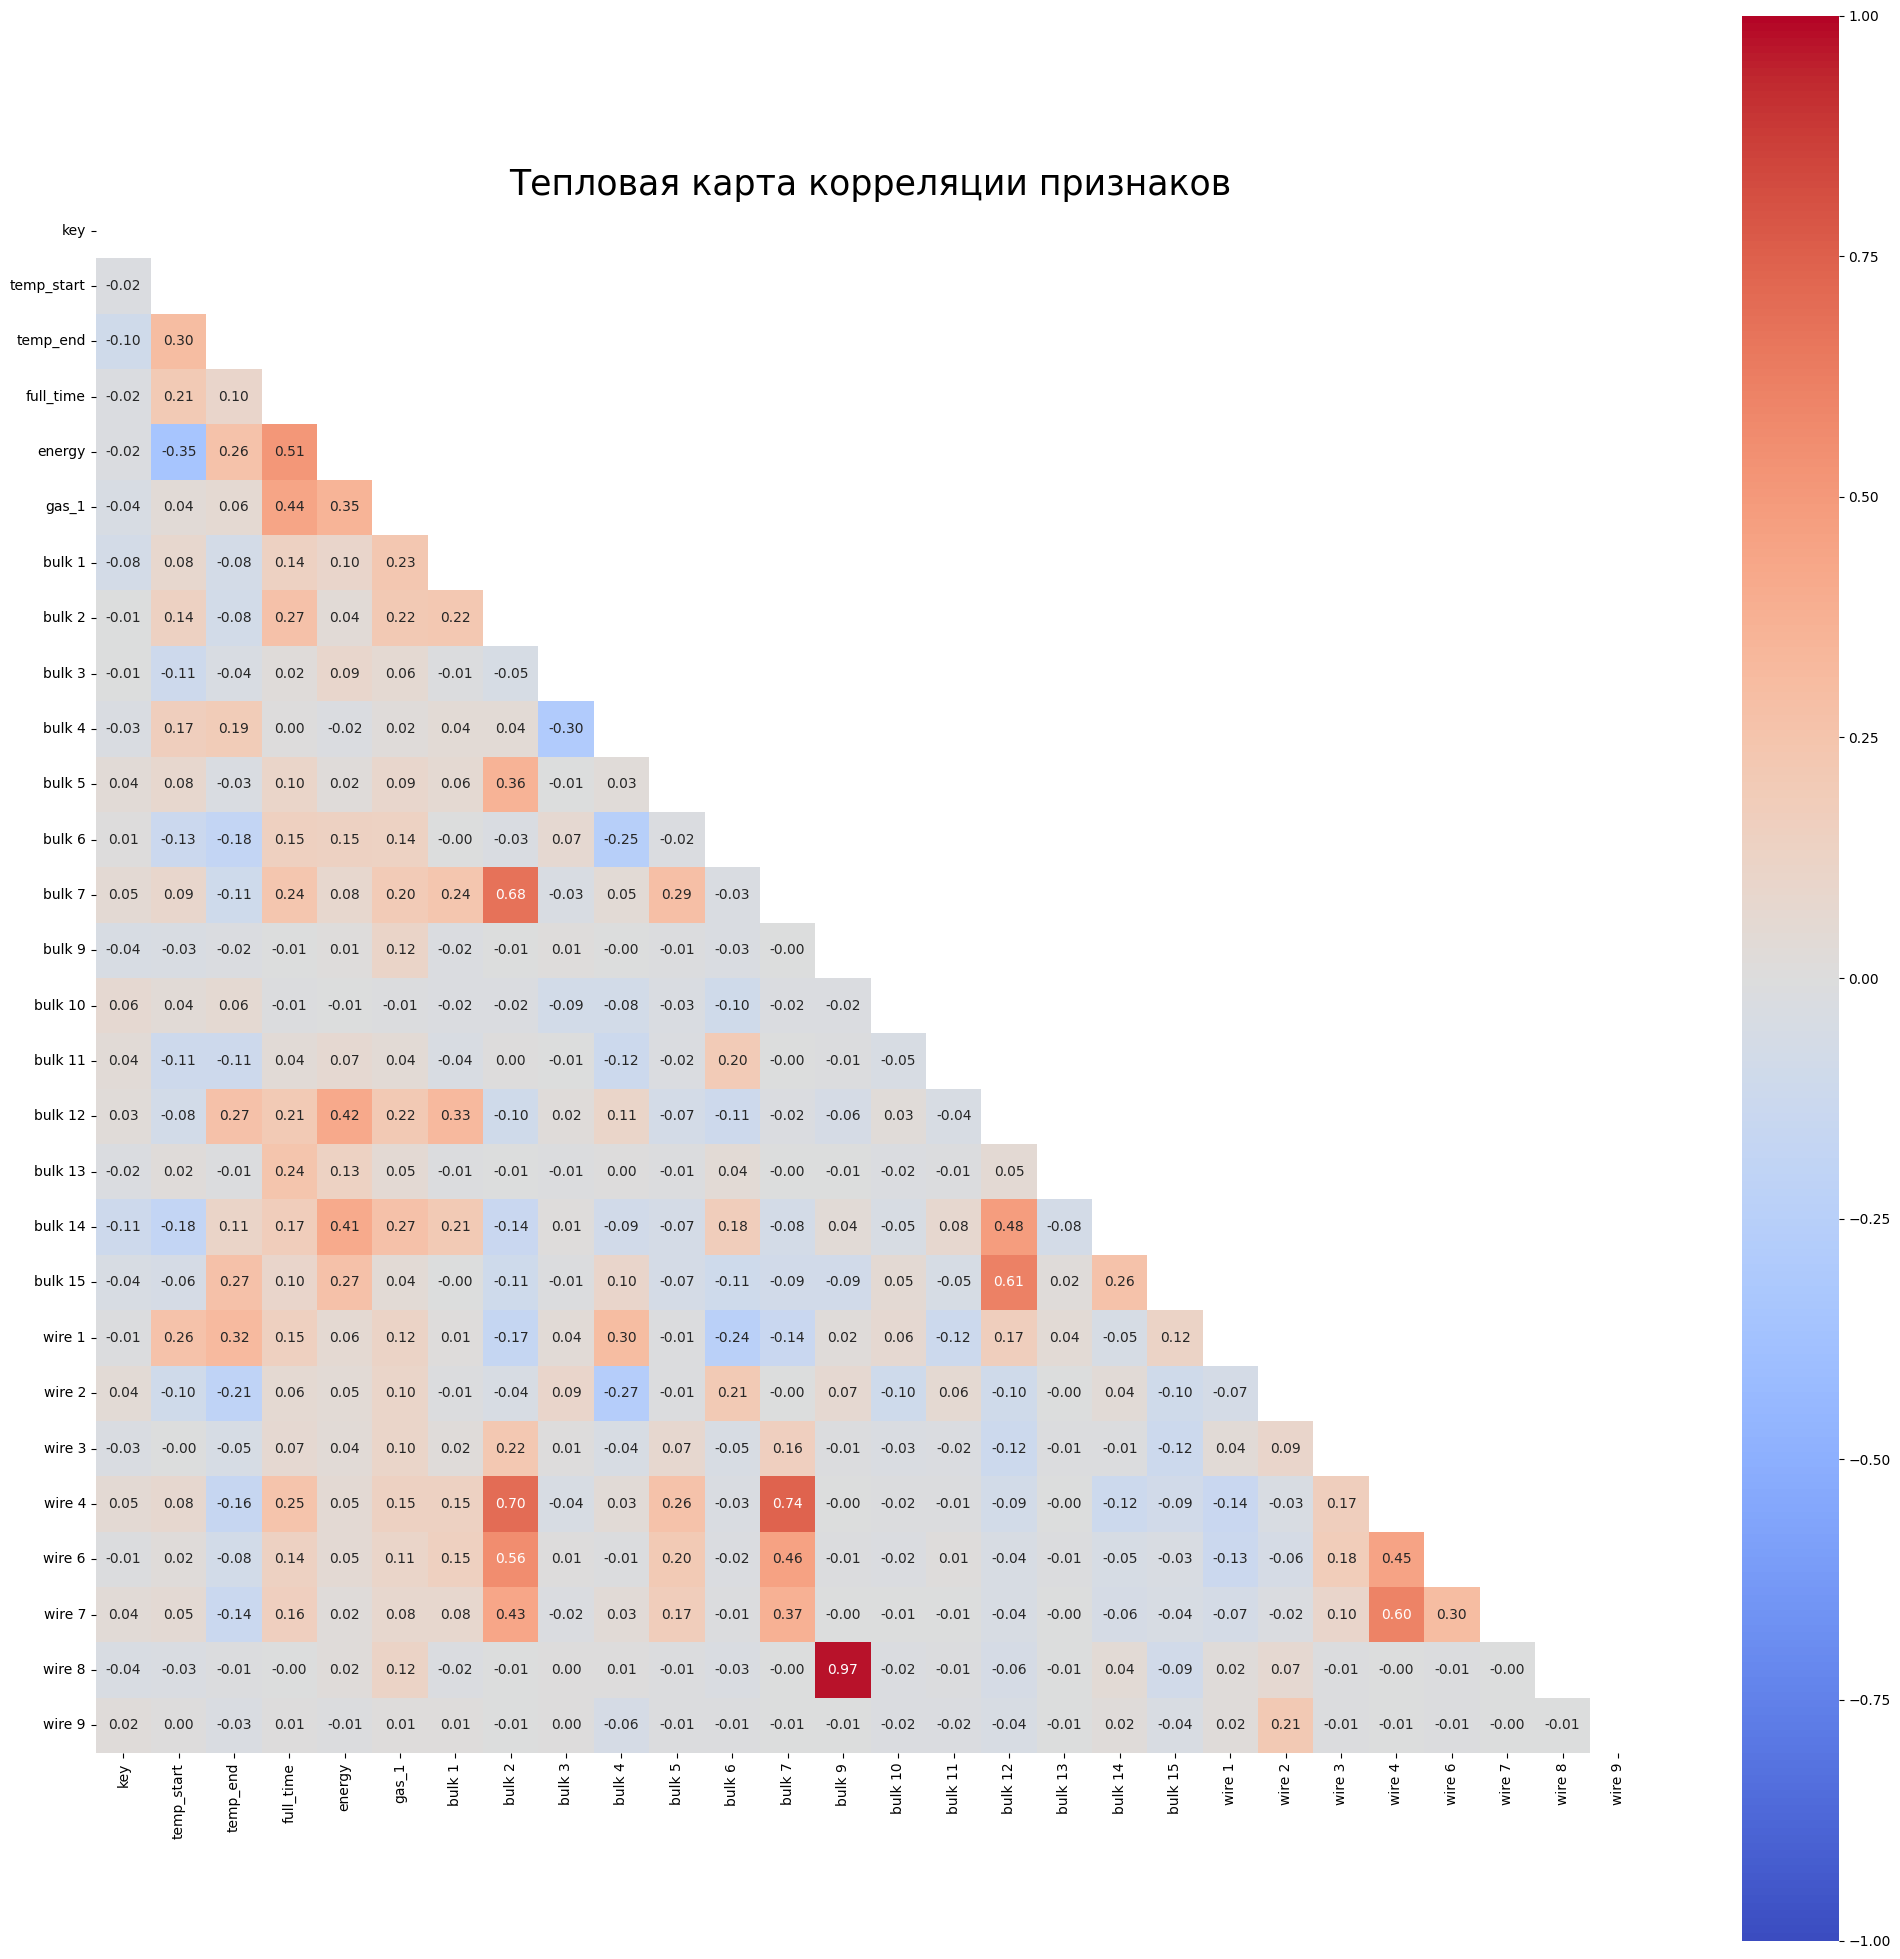

In [74]:
# построим тепловую карту всех признаков
plt.figure(figsize=(25, 25))
matrix = np.triu(data.corr())
heatmap = sns.heatmap(data.corr(),
                      annot=True,
                      mask=matrix,
                      cmap = 'coolwarm',
                      vmin = -1, vmax = +1,
                      square=True,
                      cbar=True,
                      fmt='.2f')
heatmap.set_title('Тепловая карта корреляции признаков', fontsize=25);

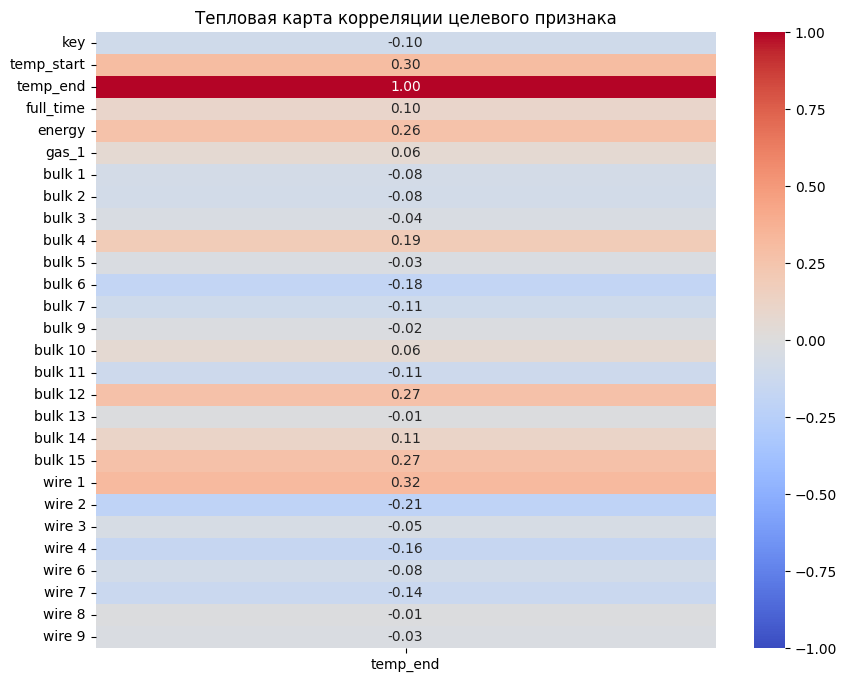

In [75]:
# построим тепловую карту корреляции целевого признака с остальными
plt.figure(figsize=(10, 8))
hm = sns.heatmap(data.corr()[['temp_end']], vmin = -1, vmax = +1, annot = True, cmap = 'coolwarm', fmt='.2f')
hm.set_title('Тепловая карта корреляции целевого признака');

Признаков, которые бы сильно коррелировали с целевым признаком в датасете нет. Максимальное значение коэффициента корреляции с целевым признаком наблюдается у следующих признаков:
- `wire 1` - коэффициент 0,32. Вероятно, это одна из основных проволочных добавок и она оказывает влияние на конечный результат. Ранее в анализе мы видели, что она используется практически во всех партиях (всего 26 пропусков во всем датасете `data_wire`).
- `temp start` - коэффициент 0,30. Логично, что начальная температура оказывает влияние на конечную.
- `bulk 12` и `bulk 15` - коэффициент 0,27. Две сыпучие добавки. Наравне с "bulk 14" являются наиболее используемыми в процессе обработки.

В целом, значение коэффициента около 0,3 показывает, что существует положительная корреляция между двумя переменными, но она довольно слабая и не имеет большого значения.

Очень высокий коэффициент корреляции в размере 0,97 наблюдается только между двумя добавками (wire 8 и bulk 9). Вероятно, обе эти легирующие добавки используются вместе. Удалим одну из них, у которой связь с целевым признаком меньше - это wire 8.

In [76]:
# до удаления (контроль)
display(data.head())

# удалим wire 8
data = data.drop(columns=['wire 8'])

# проверим результат
print('После удаления:')
data.head()

,key,temp_start,temp_end,full_time,energy,gas_1,bulk 1,bulk 2,bulk 3,bulk 4,...,bulk 14,bulk 15,wire 1,wire 2,wire 3,wire 4,wire 6,wire 7,wire 8,wire 9
0,1,1571.0,1613.0,1714.0,628.616930,29.749986,0.0,0.0,0.0,43.0,...,150.0,154.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1581.0,1602.0,1265.0,395.281800,12.555561,0.0,0.0,0.0,73.0,...,149.0,154.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2,3,1596.0,1599.0,1753.0,581.774624,28.554793,0.0,0.0,0.0,34.0,...,152.0,153.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
3,4,1601.0,1625.0,1220.0,543.710274,18.841219,0.0,0.0,0.0,81.0,...,153.0,154.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
4,5,1576.0,1602.0,1536.0,412.180480,5.413692,0.0,0.0,0.0,78.0,...,151.0,152.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0


После удаления:


,key,temp_start,temp_end,full_time,energy,gas_1,bulk 1,bulk 2,bulk 3,bulk 4,...,bulk 13,bulk 14,bulk 15,wire 1,wire 2,wire 3,wire 4,wire 6,wire 7,wire 9
0,1,1571.0,1613.0,1714.0,628.616930,29.749986,0.0,0.0,0.0,43.0,...,0.0,150.0,154.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0
1,2,1581.0,1602.0,1265.0,395.281800,12.555561,0.0,0.0,0.0,73.0,...,0.0,149.0,154.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0
2,3,1596.0,1599.0,1753.0,581.774624,28.554793,0.0,0.0,0.0,34.0,...,0.0,152.0,153.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0
3,4,1601.0,1625.0,1220.0,543.710274,18.841219,0.0,0.0,0.0,81.0,...,0.0,153.0,154.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0
4,5,1576.0,1602.0,1536.0,412.180480,5.413692,0.0,0.0,0.0,78.0,...,0.0,151.0,152.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0


**Вывод:** мы подготовили датасет к машинному обучению. В результате проверки на корреляцию признаков обнаружили сильную корреляцию между двумя добавками и удалили данные по одной из них (wire 8) из датасета.

Признаков, сильно коррелирующих с целевым, в датасете нет.

## Обучение моделей

Поскольку требуется предсказать температуру стали, то перед нами стоит **задача регресии**.

### Подготовка признаков, масштабирование

Разделим исходные данные на обучающую и тестовую выборки. Размер тестовой выборки определен Заказчиком - 25%. Также удалим из таблицы признаков столбец `key`, поскольку номер партии не влияет на результат.

In [77]:
# Выделим целевой признак
features = data.drop(['temp_end', 'key'], axis=1)
target = data['temp_end']

# Разделим данные на 2 выборки: 25% тестовая и 75% обучающая
X_train, X_test, y_train, y_test = \
    train_test_split(features, target, test_size=0.25, random_state=RANDOM_STATE)

# Проверим размер получившихся выборок
display(X_train.shape)
display(X_test.shape)

(1743, 25)

(581, 25)

Для некоторых моделей машинного обучения необходимо **масштабировать признаки** (например, для линейной регрессии). Модели на основе деревьев могут обучаться и без масштабирования. Масштабируем признаки и сохраним результат в отдельной переменной - для моделей регрессии.

In [78]:
# масштабирование
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scale = scaler.transform(X_train)
X_test_scale = scaler.transform(X_test)

### Linear Regression

In [79]:
# обучаем на масштабированных данных

model_lr = LinearRegression()
mae_lr = (cross_val_score(model_lr, X_train_scale, y_train, cv=5,
                          scoring='neg_mean_absolute_error').mean() * -1)
print('Среднее значение MAE на кросс-валидации, LinearRegression =', mae_lr)

Среднее значение MAE на кросс-валидации, LinearRegression = 6.699960354570683


### Random Forest Regressor

In [80]:
%%time

model_rf = RandomForestRegressor(random_state=RANDOM_STATE)

parameters_rf = {'n_estimators': range(18, 22, 2), #уменьшила диапазон для быстроты. Подбирала на бОльшем диапазоне
                 'min_samples_leaf': range(2, 4),  #уменьшила диапазон для быстроты. Подбирала на бОльшем диапазоне
                 'max_depth': range(6, 9)}         #уменьшила диапазон для быстроты. Подбирала на бОльшем диапазоне

grid_rf = GridSearchCV(model_rf, parameters_rf, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_rf.fit(X_train, y_train)

display('Лучшие параметры случайного леса:', grid_rf.best_params_)
display('Среднее значение MAE на кросс-валидации, RandomForestRegressor:', grid_rf.best_score_ * -1)

'Лучшие параметры случайного леса:'

{'max_depth': 8, 'min_samples_leaf': 3, 'n_estimators': 20}

'Среднее значение MAE на кросс-валидации, RandomForestRegressor:'

6.422247152162169

CPU times: user 706 ms, sys: 89.7 ms, total: 796 ms
Wall time: 15.2 s


### CatBoostRegressor

In [81]:
%%time

model_cat = CatBoostRegressor(verbose=300, random_state=RANDOM_STATE)

mae_cat = (cross_val_score(model_cat, X_train, y_train, cv=5, scoring='neg_mean_absolute_error').mean() * -1)
print('Среднее значение MAE на кросс-валидации, CatBoostRegressor', mae_cat)

Learning rate set to 0.043149
0:	learn: 10.8261696	total: 52.5ms	remaining: 52.5s
300:	learn: 6.0401086	total: 3.35s	remaining: 7.77s
600:	learn: 4.7308908	total: 5.02s	remaining: 3.33s
900:	learn: 3.8363813	total: 7.87s	remaining: 865ms
999:	learn: 3.5738719	total: 8.57s	remaining: 0us
Learning rate set to 0.043149
0:	learn: 10.8732658	total: 7.47ms	remaining: 7.46s
300:	learn: 5.9187349	total: 1.86s	remaining: 4.31s
600:	learn: 4.6317519	total: 3.54s	remaining: 2.35s
900:	learn: 3.7698384	total: 4.76s	remaining: 523ms
999:	learn: 3.5125818	total: 5.61s	remaining: 0us
Learning rate set to 0.043149
0:	learn: 10.5843020	total: 8.45ms	remaining: 8.45s
300:	learn: 5.9982697	total: 2s	remaining: 4.65s
600:	learn: 4.6490745	total: 3.3s	remaining: 2.19s
900:	learn: 3.7100719	total: 5.44s	remaining: 598ms
999:	learn: 3.4748599	total: 6.34s	remaining: 0us
Learning rate set to 0.043154
0:	learn: 10.9348471	total: 7.05ms	remaining: 7.04s
300:	learn: 5.9040683	total: 2.17s	remaining: 5.04s
600:	l

### LGBMRegressor

In [82]:
%%time
model_lgbm = LGBMRegressor(random_state=RANDOM_STATE)
parameters_lgbm = {'num_leaves': [8, 10],     #уменьшила диапазон для быстроты. Подбирала на бОльшем диапазоне
                   'learning_rate': [0.1],    #уменьшила диапазон для быстроты. Подбирала на бОльшем диапазоне
                   'max_depth': [5, 7]}           #уменьшила диапазон для быстроты. Подбирала на бОльшем диапазоне

grid_lgbm = GridSearchCV(model_lgbm, parameters_lgbm, scoring='neg_mean_absolute_error', cv=5)
grid_lgbm.fit(X_train, y_train)

display('Лучшие параметры LGBM:', grid_lgbm.best_params_)
display('Среднее значение MAE на кросс-валидации, LGBM:', grid_lgbm.best_score_ * -1)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000558 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2057
[LightGBM] [Info] Number of data points in the train set: 1394, number of used features: 18
[LightGBM] [Info] Start training from score 1593.086801
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000362 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can se

'Лучшие параметры LGBM:'

{'learning_rate': 0.1, 'max_depth': 5, 'num_leaves': 10}

'Среднее значение MAE на кросс-валидации, LGBM:'

6.2188198373031565

CPU times: user 1.79 s, sys: 68.6 ms, total: 1.86 s
Wall time: 2.04 s


### Сравнительный анализ моделей

Сведем все результаты в одну таблицу и проанализируем качество моделей, все результаты приведены на кросс-валидации, cv=5.

In [83]:
# Итоговая таблица
result = {'MAE': [mae_lr, grid_rf.best_score_ * -1, mae_cat, grid_lgbm.best_score_ * -1]}
df_result = pd.DataFrame(result, index =['LinearRegression', 'RandomForestRegressor', 'CatBoostRegressor', 'LGBMRegressor'])
df_result

,MAE
LinearRegression,6.699960
RandomForestRegressor,6.422247
CatBoostRegressor,6.251437
LGBMRegressor,6.218820


**Вывод:** лучший результат показала модель LGBMRegressor с гиперпараметрами {'learning_rate': 0.1, 'max_depth': 5, 'num_leaves': 10}. Проверим её на тестовой выборке.

## Проверка лучшей модели

### Проверка на тестовой выборке

In [84]:
# Получим предсказания
y_pred = grid_lgbm.predict(X_test)

# Рассчитаем и выведем MAE
result_lgbm = mean_absolute_error(y_test, y_pred)
print('MAE на тестовой выборке:', result_lgbm.round(3))

MAE на тестовой выборке: 6.694


Итак, на тестовой выборке мы получили значение MAE = 6.694, что удовлетворяет требованиям Заказчика (менее 6.8). **Лучшая модель - LGBMRegressor со следующими гиперпараметрами: {'learning_rate': 0.1, 'max_depth': 5, 'num_leaves': 10}.**


### Сравнение с константной моделью

Cравним результаты нашей модели с результатами константной модели. В нашем случае подойдет DummyRegressor с параметром 'mean' или 'median'. В ячейке ниже видим, что ошибка константной модели выше (MAE = 8,659), что значит, что не только наша лучшая модель, но и все обученные модели справились с задачей.

In [85]:
# стратегия "среднее значение"
model_dummy = DummyRegressor(strategy="mean")
model_dummy.fit(X_train, y_train)
predictions_test_dummy = model_dummy.predict(X_test)
result_test_dummy = mean_absolute_error(y_test, predictions_test_dummy)
print('MAE dummy "mean":', result_test_dummy.round(3))

# стратегия "медиана"
model_dummy = DummyRegressor(strategy="median")
model_dummy.fit(X_train, y_train)
predictions_test_dummy = model_dummy.predict(X_test)
result_test_dummy = mean_absolute_error(y_test, predictions_test_dummy)
print('MAE dummy "median":', result_test_dummy.round(3))

MAE dummy "mean": 8.684
MAE dummy "median": 8.659


### Исследование важности признаков

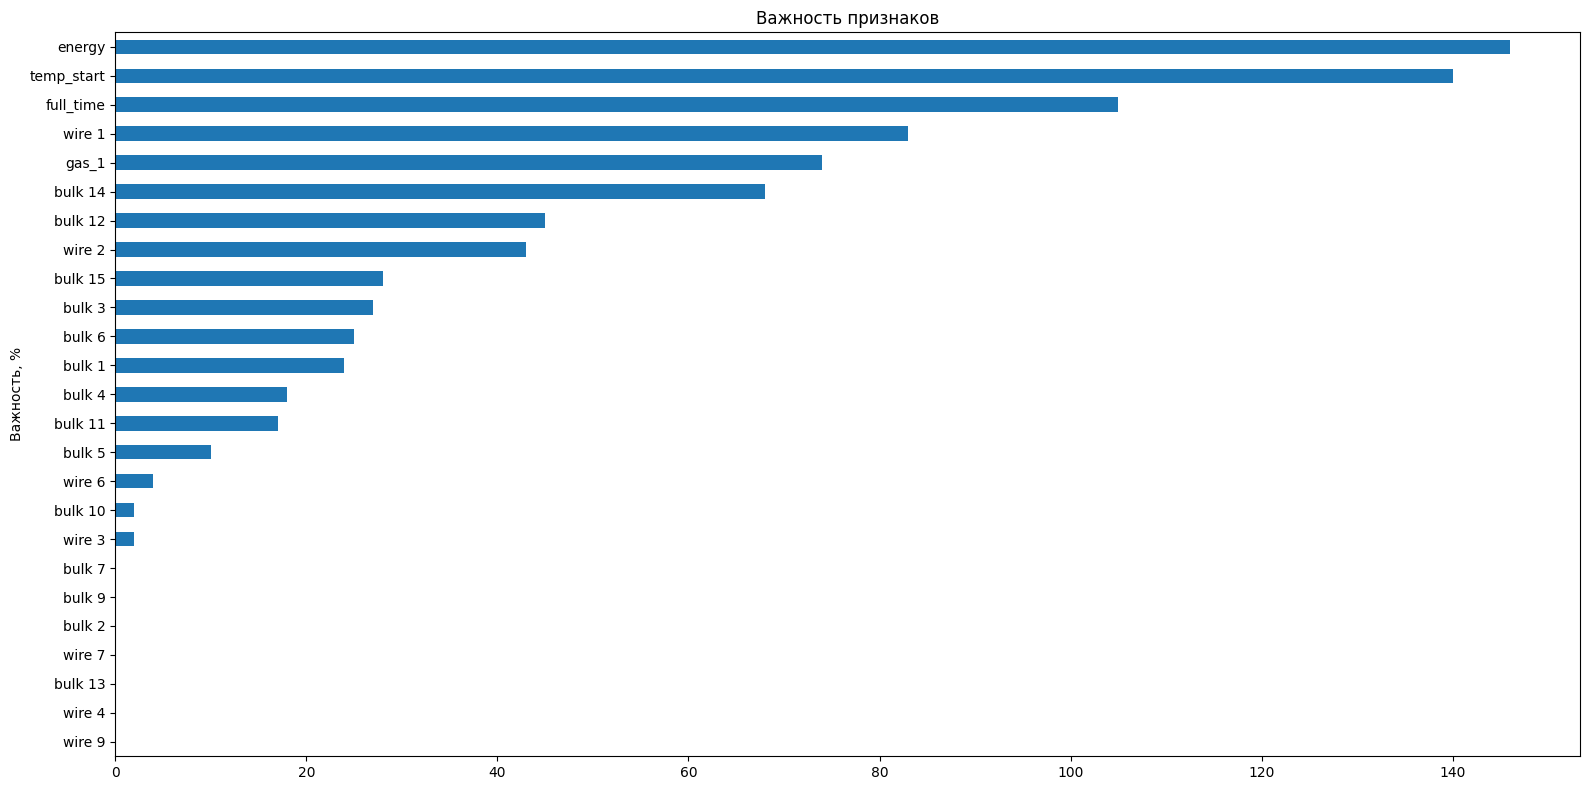

In [86]:
# построим график важности признаков
lgbm_imp = pd.Series(grid_lgbm.best_estimator_.feature_importances_, X_train.columns).sort_values()
fig, ax = plt.subplots(figsize=(16, 8))
lgbm_imp.plot.barh(ax=ax)
ax.set_title('Важность признаков')
ax.set_ylabel('Важность, %')
fig.tight_layout()

**Вывод**:

как видно на графике, наибольшее влияние на целевой признак оказывают следующие признаки (перечислены в порядке убывания):
- `energy`;
- `temp_start`;
- `full_time`;
- `wire 1`;
- `gas 1`.

При этом многие добавки, напротив, не оказывают влияние на обучение модели. Это признаки 'bulk 2', 'bulk 7', 'bulk 9', 'bulk 13', 'wire 4', 'wire 7', 'wire 9'.

### Вывод

- в данном проекте было обучено 4 модели;
- качество моделей измерялось метрикой MAE, целевое значение - меньше 6,8;
- наименьшее значение MAE показала модель LGBMRegressor с гиперпараметрами 'learning_rate': 0.1, 'max_depth': 5, 'num_leaves': 10;
- лучшая модель была проверена на тестовой выборке и показала значение MAE в размере 6,694;
- в сравнении с константной моделью выбранная модель показывает существенно более хороший результат;
- наибольшее влияние на целевой признак оказывают следующие признаки (перечислены в порядке убывания): `energy`, `temp_start`, `full_time`, `wire 1`, `gas 1`.

## Итоговый отчет

### Вводные данные, цель проекта

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали.

**Цель проекта** - обучить модель, которая предскажет температуру стали после добавления всех легирующих добавок, что позволит бизнесу снизить затраты на электричество и обслуживание/ремонт оборудования.

**Задачи проекта** - выгрузить и изучить данные; провести предобработку и исследовательский анализ данных; обучить несколько моделей на тренировочной выборке и выбрать лучшую по целевой метрике; выбрать лучшую модель и проверить её на тестовой выборке;  обобщить выводы, подготовить отчет для заказчика.

### Сравнение плана и решения, анализ основных трудностей проекта

Перед началом работы был составлен **план выполнения**, включающий следующие пункты (кратко):
1. Загрузка данных.
2. Исследование каждого датафрейма.
3. Предобработка данных:
   - работа с пропусками;
   - работа с аномалиями.
4. Определение необходимости генерации новых признаков (суммарная мощность или энергия). Их генерация.
5. Агрегирование данных по ключу.
5. Формирование итогового датафрейма.
6. Исследование итогового датафрейма, предобработка.
7. Подготовка датасета к обучению (разделение на train/test, масштабирование признаков).
9. Обучение моделей, подбор гиперпараметров, выбор лучшей модели.
10. Проверка качества лучшей модели на тестовой выборке.
11. Сравнение результатов лучшей модели с константной моделью.
12. Исследование важности признаков.
13. Написание отчета с выводами.

Все пункты плана были выполнены, в результате достигнут требуемый заказчиком результат. В процессе работы были обнаружены признаки с высокой корреляцией, в процессе предобработки итогового датафрейма с ними была проведена работа, что подробно описано в следующем абзаце.

Можно выделить следующие **сложности, возникшие во время работы над проектом,** а также **способы их решения**:
- разрозненность исходных данных. Вся информация была предоставлена заказчиком в 7 датасетах. При объединении таблиц данные предварительно были агрегированы по номеру партии.
- большое количество пропусков в данных, таблицы с лишней информацией. В результате были определены лишние таблицы (`data_bulk_time`, `data_wire_time`) - для дальнейшей работы они не использовались. В таблицах `data_bulk` и `data_wire` пропуски были заменены нулями; в таблице `data_temp` удалены партии с пропусками в температуре целиком.
- аномалии/выбросы в данных. В процессе работы было найдено несколько ошибочных данных, все партии, содержащие такие ошибочные данные, были удалены из итогового датасета. В таблице `data_arc` - отрицательное значение реактивной мощности. В таблице `data_temp` - температура ниже плавления стали (около 1200), а также партии только с 1 замером температуры, что неинформативно для дальшейших целей обучения.
- проблема мультиколлинеарности признаков. В процессе работы была обнаружена высокая корреляция между признаками "Активная мощность" и "Реактивная мощность", было принято решение на их основе рассчитать новый признак "Энергия", а данные по мощностям удалить. Также был обнаружен высокий коэффициент корреляции между некоторыми легирующими добавками. В результате из датасета был удален тот признак, у которого связь с целевым признаком меньше.
- во всех датасетах количество партий было разное, поэтому при объединении таблиц для анализа былии взяты только те партии, данные по которым были во всех датасетах.

### Описание ключевых шагов проекта

В процессе работы над проектом были выполнены следующие шаги:
- `EDA` - исследовательский анализ данных. В процессе EDA были обнаружены основные проблемы с данными - пропуски, ошибки, аномалии, высокая корреляция между признаками и т.п.
- `Предобработка данных и генерация новых признаков`. Была проведена работа с пропусками и аномалиями, удалена вся лишняя информация, добавлены новые признаки - энергия и общее время нагрева по партии. В ходе данного этапа данные были сагрегированы по номеру партии (key), а затем была сформирована итоговая таблица признаков для дальнейшего обучения.
- `Обучение моделей, настройка гиперпараметров` - в рамках этапа было обучено 4 разных модели (линейная регрессия, случайный лес, CatBoost, LGBM), для каждой из которых были подобраны гиперпараметры с целью улучшения метрики. В результате была определена лучшая модель.
- `Тестирование лучшей модели` - лучшая модель была проверена на тестовой выборке. Для проверки качества модели проведено сравнение с константной моделью и исследование важности признаков.

### Описание признаков, используемых в модели

Подготовленный к обучению датасет включает в себя 25 признаков (не считая целевого), рассмотрим их поподробнее:
- из таблицы `data_arc` в итоговый датасет попал новый расчетный признак "Энергия". Признак рассчитан на основании данных об "Активной мощности" и времени нагрева. Все остальные данные удалены на ненадобностью.
- из таблицы `data_bulk` использованы все данные о добавках, кроме "bulk 8", поскольку эта добавка использовалась всего единожды за все время наблюдений. Все пропуски в данных были заменены нулями.
- из таблицы `data_gas` взяты данные о продувке сплава газом. Предобработка не проводилась, т.к. данные в таблице внесены корректно.
- из таблицы `data_temp` использованы данные о начальной и конечной (целевой признак) температуре по партии. Дополнительно был рассчитан новый признак "общее время нагрева по партии". В процессе предобработки были удалены партии полностью, где наблюдались: пропуски, единственный замер температуры в партии, аномальная температура (ниже 1500 градусов).
- из таблицы `data_wire` использованы все данные о добавках, кроме "wire 8", поскольку эта добавка имела высокий коэффициент корреляции с другой сыпучей добавкой. Было принято решение удалить одну из них.
- таблицы `data_bulk_time` и `data_wire_time` не использовались в итоговом датасете.

### Описание лучшей модели и ее качество

Лучшей моделью была выбрана модель **LGBMRegressor со следующими гиперпараметрами**:
- learning_rate = 0.1,
- max_depth = 5,
- num_leaves = 10.

Используемый random state = 140823.

Модель показала MAE на кросс-валидации (5 фолдов) в размере 6.219 на тренировочной выборке. При проверке на тестовой выборке **метрика MAE составила 6.694**. Это означает, что модель ошибается на 6.7 градусов при прогнозировании.

Обученная нами модель достигла значения метрики, требуемого Заказчиком. В сравнении с константной моделью она показывает лучший результат (DummyRegressor,  MAE = 8.659).

### Рекомендации по улучшению

Лучшая модель была проанализована с точки зрения важности признаков. Можно отметить, что многие добавки не оказывают влияние на конечную температуру. Это признаки 'bulk 2', 'bulk 7', 'bulk 9', 'bulk 13', 'wire 4', 'wire 7', 'wire 9'. Данный факт стоит учесть в дальнейшем при планировании производственного процесса. Также можно убрать данные признаки из набора признаков для обучения, что может позитивно отразиться на качестве модели.